# Facial_key_points

### IMPORT PACKAGES

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

if torch.backends.mps.is_available():
    print("MPS backend is available!")
else:
    print("MPS backend is not available.")

# os.chdir('/Users/romankasichhwa/Desktop/Facial_key_points') #manage path accordingly!
# print(os.getcwd())

MPS backend is not available.


In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### HYPERPARAMETERS

In [83]:
batch_size = 16
model_input_size = 224
learning_rate = 0.001
n_epoch = 10


### DATALOADER

In [114]:
class FacialKeyPointsDataset(Dataset):
    def __init__(self, csv_file_path = r'data/training_frames_keypoints.csv', split = 'training',device=torch.device('cpu')):  
        super().__init__()
        self.csv_file_path = csv_file_path
        self.split = split
        self.df = pd.read_csv(self.csv_file_path)
        # print(self.df)    -->1
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],   #[r,g,b]
            std=[0.229, 0.224, 0.225]
        )
        self.device = device
        
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        img, original_size = self.get_img(idx)
        facial_keypoints = self.get_keypoints(index = idx, original_size = original_size)
        return img, facial_keypoints
    
    
    def get_img(self, index):    # to get img from  training folder using the keypoints df
        # print(self.df.iloc[index,0])   # --> 3
        # print(os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0]))   # ---> 4
        img_path = os.path.join(os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0]))
        img = Image.open(img_path).convert('RGB')
        original_size = img.size
        # print(original_size)    # ---> 5
        
        #pre-process image  ( normalizing and then converting to tensors)
        img = img.resize((model_input_size, model_input_size))
        # print(img.size)
        # print(np.asarray(img))
        img = np.asarray(img)/255.0  #range of pixel value is between 0(black) and 255(white), we normalize it to [0,1]
        # print(img.shape)  ---> (224,224,3)  i.e ( height , width, channels(RGB))
        
        
        #but in pytorch image_tensor should nbe represented in standard form ( batch,channel, width,height), to solve it we use permute 
        img = torch.tensor(img,dtype= torch.float32).permute(2,0,1)
        # print(img.shape)    --> torch.Size([1, 3, 224, 224])
        img = self.normalize(img)
        # print(img)
        return img.to(self.device), original_size
    
    
    
    def get_keypoints(self, index,original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)  # since kp_x,y is list ,we cant divide it by int . So, we use broadcasting concept in numpy
        kp_x = kp[0::2] / original_size[0]
        kp_y = kp[1::2] / original_size[1]
        kp = np.concatenate([kp_x, kp_y]).astype(np.float32)  # required ip to the model 
        # print(type(kp))
        # print(kp)
        return torch.tensor(kp).to(self.device)
    
    
    def load_img(self, index): # to use it for visualization 
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((model_input_size, model_input_size))
        return np.asarray(img) / 255.0
        
        
        
        
        
    
    
training_data = FacialKeyPointsDataset(device=device)
# print(training_data[0])
# img_tensor, kp_s = training_data[0]  #-->2
test_data = FacialKeyPointsDataset(csv_file_path=r'data/test_frames_keypoints.csv', split='test', device=device)

In [115]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [116]:
batch_img, batch_key_points = next(iter(train_dataloader))
batch_img.shape, batch_key_points.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 136]))

### DATA VISUALIZATION

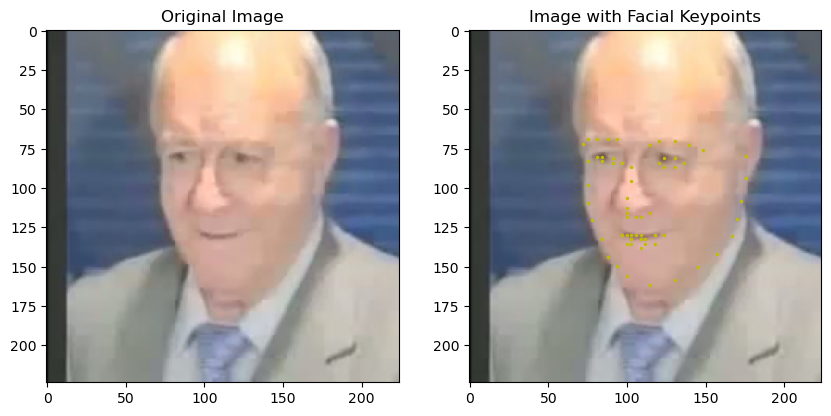

In [117]:
img_index = 26
img = training_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)   #(nrows, ncols, index)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='y',s = 2) # denormalize keypoints (kp_x * 224, kp_y*224)

### MODEL BUILDING

In [118]:
def get_model(device): # we'll be using transfer-learning
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for layers in model.parameters():
        layers.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()  # sigmoid because all points are important
    )
    return model.to(device=device)
model = get_model(device=device)

In [119]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [120]:
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward Pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    # backward Pass
    loss.backward()
    optimizer.step()

    return loss 

In [121]:
@torch.no_grad()
def validation_batch(imgs, kps, model, criterion):
    model.eval()

    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)
    return loss

### Training

In [122]:
train_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0 

    # train 
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        # images, kps = 
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss+= loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)
   
    # validation
    for images, kps in tqdm(test_dataloader, desc="validation"):
        loss = validation_batch(images, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_dataloader)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}")

Training 1 of 10:  67%|██████▋   | 146/217 [06:01<02:56,  2.48s/it]


KeyboardInterrupt: 

### TRAIN AND TEST CURVE PLOTS

In [ ]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

### INFERENCE



In [ ]:
img_index = 11
img = test_data.load_img(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='y',s = 2)